# Loading data and following this example:
https://rhodesmill.org/skyfield/planetary.html

In [1]:
from skyfield.api import PlanetaryConstants, load

ts = load.timescale()
t = ts.utc(2019, 12, 20, 11, 5)

eph = load('de421.bsp')
earth, moon = eph['earth'], eph['moon']

pc = PlanetaryConstants()
pc.read_text(load('moon_080317.tf'))
pc.read_text(load('pck00008.tpc'))
pc.read_binary(load('moon_pa_de421_1900-2050.bpc'))

frame = pc.build_frame_named('MOON_ME_DE421')
aristarchus = moon + pc.build_latlon_degrees(frame, 26.3, -46.8)

apparent = earth.at(t).observe(aristarchus).apparent()
ra, dec, distance = apparent.radec(epoch='date')
print(ra)
print(dec)

13h 03m 22.96s
-00deg 55' 27.3"


In [13]:
# You can learn the Moon latitude and longitude directly 
# beneath the body by observing the target from the Moon’s center 
# and then asking the lunar reference frame for the latitude and longitude.
sun = eph['Sun']

p = moon.at(t).observe(sun).apparent()
lat, lon, distance = p.frame_latlon(frame)
lon_degrees = (lon.degrees + 180.0) % 360.0 - 180.0
print('Sub-solar latitude: {:.1f} degrees'.format(lat.degrees))
print('Sub-solar longitude: {:.1f} degrees'.format(lon_degrees))

Sub-solar latitude: 0.3 degrees
Sub-solar longitude: -104.9 degrees


# Load georeferenced Moon
Credit to Eleanor Lutz for her fantastic work in this repository:
https://github.com/eleanorlutz/moon_geology_atlas_of_space/blob/main/3_plot_landing_sites.ipynb

For our use case, we will use her method of loading a geo-referenced Moon, then plot some custom ground tracks.

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

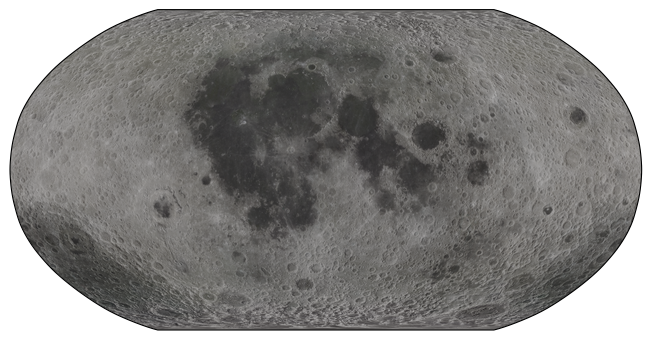

In [3]:
# This sets the geographic 'extent' of the supplied image, so we get a georefrenced projection.
orthos = [[0, 90], [0, -90], [0, 0], [180, 0]]
img = plt.imread("moon.png")

# Original code by Eleanor:
# for orth in orthos: 
#     savename = './figures/moon_'+str(orth[0])+'_'+str(orth[1])+'_surface.png'
#     fig = plt.figure(figsize=(6, 6))
#     ax = plt.axes(projection=ccrs.Orthographic(*orth))
#     ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree(), 
#               interpolation='spline36', regrid_shape=4000)
#     # ax.set_global()
#     # ax.outline_patch.set_edgecolor('none')
#     if orth == orthos[1]:
#         show = False

# We reformulate the above approach to focus on a single extent, then plot that.
# This projection lets us see the most of the Moon's surface.
proj = ccrs.Robinson()
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), constrained_layout=True)

ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree(), 
              interpolation='spline36', regrid_shape=4000)

plt.show()

# Test if the image is georeferenced
- We can scatter some points at different latitudes and longitudes
- By checking if these show up where we expect, we can proceed with further analysis.

In [4]:
def add_text(x, y, text, **kwargs):
    """ Helper function to avoid having to repeat the same arguments when adding locations to the map. """
    ax.text(x, y, text, transform=ccrs.PlateCarree(), verticalalignment='top', fontsize=14, c='red', bbox={'facecolor': 'black', 'alpha': 0.8, 'pad': 3}, **kwargs)

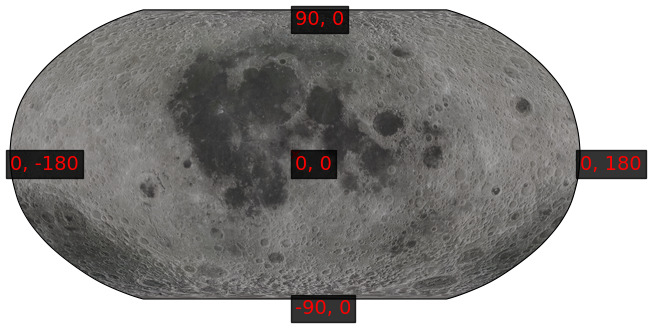

In [9]:
locations = {'0, 0': (0, 0), '90, 0': (90, 0), 
             '-90, 0': (-90, 0), '0, -180': (0, -180),
             '0, 180': (0, 180)}

keys = [key for key in locations]

# This sets the geographic 'extent' of the supplied image, so we get a georefrenced projection.
orthos = [[0, 90], [0, -90], [0, 0], [180, 0]]
img = plt.imread("moon.png")

# We reformulate the above approach to focus on a single extent, then plot that.
# This projection lets us see the most of the Moon's surface.
proj = ccrs.Robinson()
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), constrained_layout=True)

ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree(), 
              interpolation='spline36', regrid_shape=4000)

for i, key in enumerate(keys):
    ax.plot(locations[key][1], locations[key][0], transform=ccrs.Robinson(), color='red', linewidth=4, marker='x')
    add_text(locations[key][1], locations[key][0], key)

plt.show()

## Caveats, assumptions
Now that the above shows that our image is correctly geo-referenced, we can proceed with plotting a ground track for the Moon, given orbital elements.

However, the Skyfield API can only 